#Dependencies

In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

#Architecture

In [21]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        #self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.fcl1 = nn.Linear(128*4*4, 1024)
        self.fcl2 = nn.Linear(1024, 512)
        #self.fcl3 = nn.Linear(512, 256)
        self.fcl4 = nn.Linear(512, 10)
  # flattening function
    def num_flat_features(self, x):
      '''
      ========================================
      calculates the flattened vector for input into the fully connected layers
      '''
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        #x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fcl1(x))
        x = F.relu(self.fcl2(x))
        #x = F.relu(self.fcl3(x))
        x = self.fcl4(x)
        return x


#Data processing

In [3]:
# Create transformations to apply to each data sample
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets for training and testing
train_dataset = datasets.CIFAR10('./data/', train=True, download=True,
                    transform=transform)
test_dataset = datasets.CIFAR10('./data/', train=False,
                    transform=transform)
train_loader = DataLoader(train_dataset, batch_size = 32,
                            shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size = 32,
                            shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:02<00:00, 78522086.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/


#Utility Functions

In [4]:
def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''
    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # Compute loss based on criterion
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # Count correct predictions overall
        for i, element in enumerate(pred):
          if pred[i] == target[i]:
            correct += 1

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

In [5]:
def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # Compute loss based on same criterion as training
            criterion = nn.CrossEntropyLoss()
            # Compute loss based on same criterion as training
            loss = criterion(output, target)

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # Count correct predictions overall
            for i, element in enumerate(pred):
              if pred[i] == target[i]:
                correct += 1

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

In [6]:
def show_image(img, label, batch_size):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

In [8]:
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

#Training

Torch device selected:  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [32, 3, 32, 32]               0
            Conv2d-2           [32, 32, 32, 32]             896
            Conv2d-3           [32, 64, 16, 16]          18,496
            Conv2d-4            [32, 128, 8, 8]          73,856
            Linear-5                 [32, 1024]       2,098,176
            Linear-6                  [32, 512]         524,800
            Linear-7                   [32, 10]           5,130
Total params: 2,721,354
Trainable params: 2,721,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 15.13
Params size (MB): 10.38
Estimated Total Size (MB): 25.88
----------------------------------------------------------------

Train set: Average loss: 2.2858, Accuracy: 8640/50016 (17%)

Test set

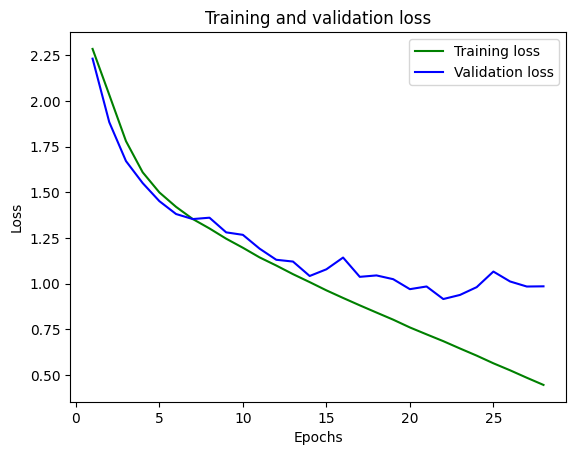

In [23]:
learning_rate = .001  # optimizer learning rate
momentum = .9 # optimizer momentum
num_epochs = 30 # number of training iterations
batch_size = 32 # number of samples trained each iteration
stop_threshold = 5  # early stopping threshold
best_epoch = 0  # iteration of best model
best_accuracy = 0.0 # best accuracy for early stopping \

# Check if cuda is available
use_cuda = torch.cuda.is_available()

# Set proper device based on cuda availability
device = torch.device("cuda" if use_cuda else "cpu")
print("Torch device selected: ", device)

# Initialize the model and send to device
model = ImageClassifier().to(device)
summary(model, (3, 32, 32), batch_size=batch_size)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

# Run training for n_epochs specified in config
for epoch in range(1, num_epochs + 1):
    loss, accuracy = train(model, device, train_loader,
                                    optimizer, criterion, epoch, batch_size)
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    loss, accuracy = test(model, device, test_loader)
    test_loss.append(loss)
    test_accuracy.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_epoch = epoch
        checkpoint(model, 'best_model.pth')

    elif epoch - best_epoch > stop_threshold:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop


print("accuracy is {:2.2f}".format(best_accuracy))

print("Training and evaluation finished")


# Load best model and evaluate on test set
resume(model, 'best_model.pth')
loss, accuracy = test(model, device, test_loader)

epochs = range(1, best_epoch + 1)
plt.plot(epochs, train_loss[:best_epoch], 'g', label='Training loss')
plt.plot(epochs, test_loss[:best_epoch], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Test code

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


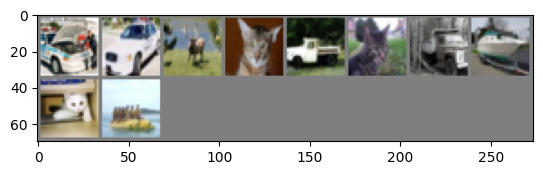

car   car   deer  cat   truck cat   truck ship  cat   ship 


In [25]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(type(dataiter))
print(type(images))
print(type(labels))
# show images
show_image(torchvision.utils.make_grid(images), labels, batch_size)

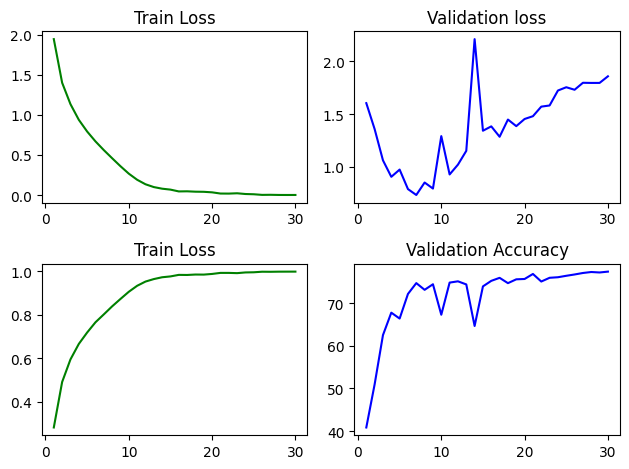

In [27]:
figure, axis = plt.subplots(2, 2)

axis[0,0].plot(epochs, train_loss, 'g', label='loss')
axis[0,0].set_title('Train Loss')
axis[0,1].plot(epochs, test_loss, 'b', label='loss')
axis[0,1].set_title('Validation loss')
axis[1,0].plot(epochs, train_accuracy, 'g', label='accuracy')
axis[1,0].set_title('Train Loss')
axis[1,1].plot(epochs, test_accuracy, 'b', label='accuracy')
axis[1,1].set_title('Validation Accuracy')
figure.tight_layout()
plt.show()

Test set: Average loss: 0.8566, Accuracy: 7477/10000 (75%)



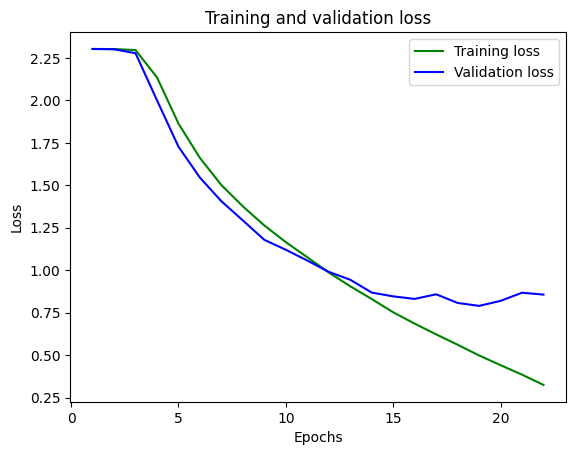

In [15]:
loss, accuracy = test(model, device, test_loader)

epochs = range(1, best_epoch + 1)
plt.plot(epochs, train_loss[:best_epoch], 'g', label='Training loss')
plt.plot(epochs, test_loss[:best_epoch], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()